## imports, etc.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import os
from sklearn.semi_supervised import LabelPropagation
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
Xv_train = torch.load("data/FashionMNIST_train_latent.pt")
Xv_test = torch.load("data/FashionMNIST_test_latent.pt")
Xv = torch.cat((Xv_train, Xv_test), 0)
y_train = torch.load("data/FashionMNIST_train_labels.pt")
y_test = torch.load("data/FashionMNIST_test_labels.pt")
y = torch.cat((y_train, y_test), 0)

In [3]:
Xa_train_ = torch.load("data/AE_train.pt")
Xa_test_ = torch.load("data/AE_test.pt")
Xa = torch.cat((Xa_train_, Xa_test_), 0).detach().cpu()

In [4]:
os.chdir("../fashion_ml")

In [5]:
from fashion_vae import FashionVAE
from data_loader import EZ_Dataloader
from experiment import FashionML

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
trainset = torchvision.datasets.FashionMNIST(root = "./data", train = True,
                                             download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root = "./data", train = False,
                                            download = True, transform = transforms.ToTensor())

In [8]:
Xf_train = trainset.data
yf_train = trainset.targets
Xf_test = testset.data
yf_test = testset.targets

In [9]:
Xf = torch.cat((Xf_train, Xf_test), 0)
yf = torch.cat((yf_train, yf_test), 0)

In [10]:
Xf = torch.reshape(Xf, (70000, 784))

In [11]:
#np.random.seed(0)

## limit data labels

discard all but 200 random labels (we can increase the number but I feel like 1000+ doesn't really count as semi-supervised anymore)

In [106]:
n_labeled = 200

In [107]:
ind = np.random.randint(len(Xv), size=(n_labeled))
y_lim = np.repeat(-1, len(y))
y_lim[ind] = y[ind]

## compare: clustering

In [99]:
Xv_train = Xv[y_lim != -1]
Xv_test = Xv[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [100]:
Xa_train = Xa[y_lim != -1]
Xa_test = Xa[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [108]:
Xf_train = Xf[y_lim != -1]
Xf_test = Xf[y_lim == -1]
yf_train = yf[y_lim != -1]
yf_test = yf[y_lim == -1]

In [102]:
def test_knn(X_train, y_train, X_test, y_test, n):
    lpm = LabelPropagation(kernel='knn',n_neighbors=n,n_jobs=-1,max_iter=5000)
    lpm.fit(X_train, y_train)
    print(lpm.score(X_test, y_test))
    return lpm

VAE - optimal k=10

In [103]:
test_knn(Xv_train, y_train,Xv_test,y_test, 10)

0.5427936962750717


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=10)

AE: optimal k=6, better accuracy than VAE

In [104]:
test_knn(Xa_train, y_train,Xa_test,y_test, 6)

0.6670630372492836


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=6)

raw images: optimal k=3

In [109]:
test_knn(Xf_train, yf_train, Xf_test, yf_test, 3)

0.6480945558739255


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=3)

## compare: mlp

test a few networks on vae latent representations

In [30]:
Xv_train = Xv[y_lim != -1]
Xv_test = Xv[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [31]:
clf = MLPClassifier(hidden_layer_sizes=(100,20,5), tol=1e-4)
clf.fit(Xv_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 20, 5))

In [32]:
clf.score(Xv_test, y_test)

0.2633200097419808

In [44]:
clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-7)
clf.fit(Xv_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 100, 25, 5), tol=1e-07)

In [45]:
clf.score(Xv_test, y_test)

0.5036031002421169

test same networks on vanilla ae

In [35]:
Xa_train = Xa[y_lim != -1]
Xa_test = Xa[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [36]:
clf = MLPClassifier(hidden_layer_sizes=(100,20,5), tol=1e-4)
clf.fit(Xa_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 20, 5))

In [37]:
clf.score(Xa_test, y_test)

0.4571137949313047

In [66]:
clf2 = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-7)
clf2.fit(Xa_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 100, 25, 5), tol=1e-07)

In [67]:
clf2.score(Xa_test, y_test)

0.44897637569662324

## test different numbers of points

In [11]:
ns = [30, 50, 75, 100, 150, 200, 500, 750, 900, 1000, 1100, 1250, 1500, 1750, 2000]

In [12]:
def rep(n, X_dat, y_dat, c):
    ind = np.random.randint(len(y_dat), size=(n))
    y_lim = np.repeat(-1, len(y_dat))
    y_lim[ind] = y[ind]
    X_train = X_dat[y_lim != -1]
    X_test = X_dat[y_lim == -1]
    y_train = y_dat[y_lim != -1]
    y_test = y_dat[y_lim == -1]
    if c:
        clf = MLPClassifier(hidden_layer_sizes=(50,20,5), tol=1e-5)
    else:
        clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [13]:
def test_mlp(n, X_dat, y_dat, c=False):
    max_score = rep(n, X_dat, y_dat, c)
    for i in range(4):
        score = rep(n, X_dat, y_dat, c)
        if score > max_score:
            max_score = score
    return max_score

In [14]:
res = []
res2 = []
res3 = []

In [23]:
for n in ns:
    res.append(test_mlp(n, Xv, y))
    res2.append(test_mlp(n, Xa, y))
    res3.append(test_mlp(n, Xf, yf, True))

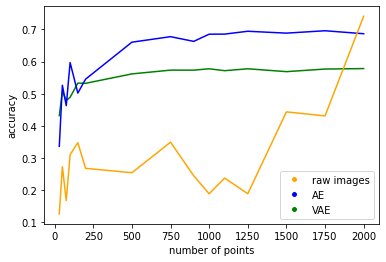

In [38]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='raw images', markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w', label='AE', markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='VAE', markerfacecolor='green')]

plt.figure(figsize=(6,4))
plt.plot(ns, res, color="green")
plt.plot(ns, res2, color="blue")
plt.plot(ns, res3, color="orange")
plt.legend(handles=legend_elements)
plt.xlabel("number of points")
plt.ylabel("accuracy")
plt.show()

In [23]:
def rep_lpm(n, X_dat, y_dat, k):
    ind = np.random.randint(len(y_dat), size=(n))
    y_lim = np.repeat(-1, len(y_dat))
    y_lim[ind] = y[ind]
    X_train = X_dat[y_lim != -1]
    X_test = X_dat[y_lim == -1]
    y_train = y_dat[y_lim != -1]
    y_test = y_dat[y_lim == -1]
    lpm = LabelPropagation(kernel='knn',n_neighbors=k,n_jobs=-1,max_iter=5000)
    lpm.fit(X_train, y_train)
    return lpm.score(X_test, y_test)

In [24]:
def test_lpm(n, X_dat, y_dat, k):
    max_score = rep_lpm(n, X_dat, y_dat)
    for i in range(4):
        score = rep_lpm(n, X_dat, y_dat)
        if score > max_score:
            max_score = score
    return max_score

## test different models

In [34]:
def rep_models(n, X_dat, y_dat):
    ind = np.random.randint(len(y_dat), size=(n))
    y_lim = np.repeat(-1, len(y_dat))
    y_lim[ind] = y[ind]
    X_train = X_dat[y_lim != -1]
    X_test = X_dat[y_lim == -1]
    y_train = y_dat[y_lim != -1]
    y_test = y_dat[y_lim == -1]
    models = [MLPClassifier, ]
    clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
    clf.fit(X_train, y_train)
    score1 = clf.score(X_test, y_test)
    lpm = LabelPropagation(kernel='knn',n_neighbors=2,max_iter=3000)
    lpm.fit(X_train, y_train)
    score2 = lpm.score(X_test, y_test)
    log = LogisticRegression()
    log.fit(X_train, y_train)
    score3 = log.score(X_test, y_test)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    score4 = rf.score(X_test, y_test)
    return [score1, score2, score3, score4]

In [35]:
def test_models(n, X_dat, y_dat, c=False):
    bests = rep_models(n, X_dat, y_dat)
    for i in range(4):
        new = rep_models(n, X_dat, y_dat)
        for i in range(len(bests)):
            if new[i] > bests[i]:
                bests[i] = new[i]
    return bests

In [36]:
mres1 = []
mres2 = []
mres3 = []
mres4 = []

In [37]:
for n in ns:
    a, b, c, d = test_models(n, Xv, y)
    mres1.append(a)
    mres2.append(b)
    mres3.append(c)
    mres4.append(d)

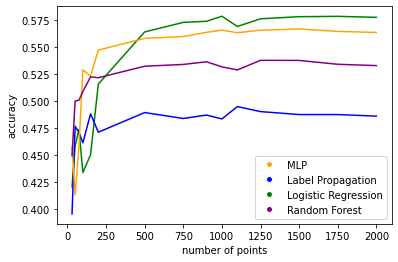

In [39]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='MLP', markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w', label='Label Propagation', markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Logistic Regression', markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w', label='Random Forest', markerfacecolor='purple')]

plt.figure(figsize=(6,4))
plt.plot(ns, mres1, color="green")
plt.plot(ns, mres2, color="blue")
plt.plot(ns, mres3, color="orange")
plt.plot(ns, mres4, color="purple")
plt.legend(handles=legend_elements)
plt.xlabel("number of points")
plt.ylabel("accuracy")
plt.show()

In [40]:
mres1_ = []
mres2_ = []
mres3_ = []
mres4_ = []

In [41]:
for n in ns:
    a, b, c, d = test_models(n, Xa, y)
    mres1_.append(a)
    mres2_.append(b)
    mres3_.append(c)
    mres4_.append(d)

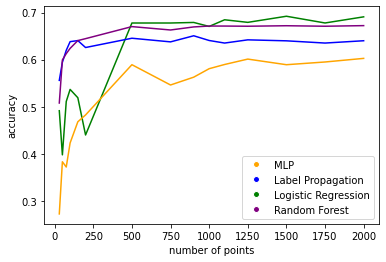

In [42]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='MLP', markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w', label='Label Propagation', markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Logistic Regression', markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w', label='Random Forest', markerfacecolor='purple')]

plt.figure(figsize=(6,4))
plt.plot(ns, mres1_, color="green")
plt.plot(ns, mres2_, color="blue")
plt.plot(ns, mres3_, color="orange")
plt.plot(ns, mres4_, color="purple")
plt.legend(handles=legend_elements)
plt.xlabel("number of points")
plt.ylabel("accuracy")
plt.show()

In [60]:
def test_models(n, X_dat, y_dat, c=False):
    bests = rep_models(n, X_dat, y_dat)
    for i in range(4):
        new = rep_models(n, X_dat, y_dat)
        for i in range(len(bests)):
            if new[i] > bests[i]:
                bests[i] = new[i]
    return bests

In [61]:
m_res1_ = []
m_res2_ = []
m_res3_ = []
m_res4_ = []

In [62]:
for n in ns:
    a, b, c, d = test_models(n, Xa, y)
    m_res1_.append(a)
    m_res2_.append(b)
    m_res3_.append(c)
    m_res4_.append(d)

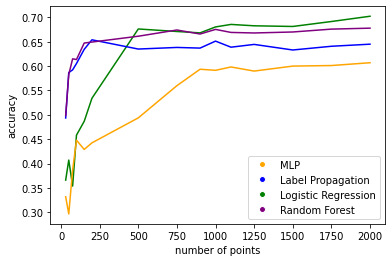

In [63]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='MLP', markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w', label='Label Propagation', markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Logistic Regression', markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w', label='Random Forest', markerfacecolor='purple')]

plt.figure(figsize=(6,4))
plt.plot(ns, m_res1_, color="green")
plt.plot(ns, m_res2_, color="blue")
plt.plot(ns, m_res3_, color="orange")
plt.plot(ns, m_res4_, color="purple")
plt.legend(handles=legend_elements)
plt.xlabel("number of points")
plt.ylabel("accuracy")
plt.show()

## final model

In [147]:
ind = np.random.randint(len(Xv), size=(n_labeled))
y_lim = np.repeat(-1, len(y))
y_lim[ind] = y[ind]

In [148]:
Xa_train = Xa[y_lim != -1]
Xa_test = Xa[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [149]:
test_knn(Xa_train, y_train,Xa_test,y_test, 6)

0.6675787965616046


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=6)